In [195]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torch import Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.fft import rfft, rfftfreq, fft, fftfreq
import scipy
import time
import copy
from google.colab import drive

drive.mount('/content/drive')

# Load in Data
with open('/content/drive/MyDrive/CSE 481 Capstone/processed_data.npy', 'rb') as f:
    data = np.load(f)
print(data.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(17920, 4, 32, 32)


In [196]:
# Load in Labels
labels = pd.read_excel("/content/drive/MyDrive/CSE 481 Capstone/metadata_xls/participant_ratings.xls")
print(labels.head())
sub_labels = []
for i in range(len(labels)):
  sub_labels.append([labels.loc[i, 'Valence'], labels.loc[i, 'Arousal']])
sub_labels = np.array(sub_labels)
print(sub_labels.shape)
print(sub_labels)
sub_labels_2 = np.zeros((len(sub_labels)))
for i in range(len(sub_labels)):
  instance = sub_labels[i]
  valence = instance[0]
  arousal = instance[1]
  if (valence < 5 and arousal < 5):
    sub_labels_2[i] = 0
  elif (valence < 5 and arousal >= 5):
    sub_labels_2[i] = 1
  elif (valence >= 5 and arousal < 5):
    sub_labels_2[i] = 2
  else:
    sub_labels_2[i] = 3
#lb = preprocessing.LabelBinarizer()
#sub_labels_2 = lb.fit_transform(sub_labels_2)
print(sub_labels_2)

# convert to windowed labels
data_labels = np.repeat(sub_labels_2, 14, axis=0)
print(data_labels.shape)
print(data_labels)

#convert to tensor
#ata = torch.tensor(data)
data = torch.from_numpy(data).float()
data_labels = torch.from_numpy(data_labels).float()
print(data.dtype)
print(data.shape)
dataset = TensorDataset(Tensor(data) , Tensor(data_labels))

print(data[29][1])

   Participant_id  Trial  Experiment_id  ...  Dominance  Liking  Familiarity
0               1      1              5  ...       7.19    6.05          4.0
1               1      2             18  ...       6.94    8.01          4.0
2               1      3              4  ...       6.12    8.06          4.0
3               1      4             24  ...       8.01    8.22          4.0
4               1      5             20  ...       7.19    8.13          1.0

[5 rows x 9 columns]
(1280, 2)
[[6.96 3.92]
 [7.23 7.15]
 [4.94 6.01]
 ...
 [8.05 7.09]
 [4.01 7.17]
 [4.08 5.95]]
[2. 3. 1. ... 3. 1. 1.]
(17920,)
[2. 2. 2. ... 1. 1. 1.]
torch.float32
torch.Size([17920, 4, 32, 32])
tensor([[ 1.0000,  0.6335,  0.4222,  ..., -0.0332,  0.3070,  0.1884],
        [ 0.6335,  1.0000,  0.8858,  ..., -0.0963,  0.4528,  0.2397],
        [ 0.4222,  0.8858,  1.0000,  ...,  0.0902,  0.4818,  0.2817],
        ...,
        [-0.0332, -0.0963,  0.0902,  ...,  1.0000,  0.4132,  0.5115],
        [ 0.3070,  0.4528, 

In [197]:
pre_train_size = int(0.9 * len(dataset))
test_size = len(dataset) - pre_train_size
pre_train_set, test_set = torch.utils.data.random_split(dataset, [pre_train_size, test_size])
train_size = int(0.8 * len(pre_train_set))
val_size = len(pre_train_set) - train_size
print(len(pre_train_set))
print(train_size)
print(val_size)
train_set, val_set = torch.utils.data.random_split(pre_train_set, [train_size, val_size])

batch_size = 128
print(len(train_set), len(val_set), len(test_set))
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
dataloaders = {
    'train': trainloader,
    'val': valloader,
}

16128
12902
3226
12902 3226 1792


In [198]:
# with auto encoder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# skipped autoencoder
model = nn.Sequential(
    nn.Conv2d(4, 32, [3, 1]),
    nn.ReLU(),
    nn.Dropout(),
    nn.Conv2d(32, 64, [3, 1]),
    nn.ReLU(), # Maybe not sure
    nn.Dropout(),
    nn.MaxPool2d([3, 3]),
    nn.Flatten(),
    nn.Linear(5760, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 4)
)
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

cuda:0
Sequential(
  (0): Conv2d(4, 32, kernel_size=[3, 1], stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Conv2d(32, 64, kernel_size=[3, 1], stride=(1, 1))
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): MaxPool2d(kernel_size=[3, 3], stride=[3, 3], padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=5760, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=4, bias=True)
)


In [199]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0
all_train_loss = []
all_val_loss = []
num_epochs = 75
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs)
            #print(labels)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                #print(outputs)
                _, preds = torch.max(outputs, 1)
                #print(preds)
                #print(outputs.dtype)
                #print(labels.dtype)
                loss = loss_func(outputs, labels.long())
                #print(loss.item())

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()

                #print(running_loss)
                
                running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase])
        epoch_acc = running_corrects / len(dataloaders[phase])

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        if phase == 'train':
          all_train_loss.append(epoch_loss)
        else:
          all_val_loss.append(epoch_loss)
        # deep copy the model
        # if phase == 'val' and epoch_acc > best_acc:
        #     best_acc = epoch_acc
        #     best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/74
----------
train Loss: 1.3677 Acc: 0.3521
val Loss: 1.3808 Acc: 0.3137

Epoch 1/74
----------
train Loss: 1.3344 Acc: 0.3667
val Loss: 1.3465 Acc: 0.3667

Epoch 2/74
----------
train Loss: 1.2942 Acc: 0.3884
val Loss: 1.3178 Acc: 0.3732

Epoch 3/74
----------
train Loss: 1.2708 Acc: 0.3979
val Loss: 1.3050 Acc: 0.3880

Epoch 4/74
----------
train Loss: 1.2573 Acc: 0.4057
val Loss: 1.2920 Acc: 0.4081

Epoch 5/74
----------
train Loss: 1.2428 Acc: 0.4152
val Loss: 1.2791 Acc: 0.4052

Epoch 6/74
----------
train Loss: 1.2340 Acc: 0.4212
val Loss: 1.2629 Acc: 0.4088

Epoch 7/74
----------
train Loss: 1.2212 Acc: 0.4282
val Loss: 1.2591 Acc: 0.4183

Epoch 8/74
----------
train Loss: 1.2122 Acc: 0.4306
val Loss: 1.2474 Acc: 0.4327

Epoch 9/74
----------
train Loss: 1.1973 Acc: 0.4408
val Loss: 1.2579 Acc: 0.4384

Epoch 10/74
----------
train Loss: 1.1892 Acc: 0.4475
val Loss: 1.2363 Acc: 0.4235

Epoch 11/74
----------
train Loss: 1.1807 Acc: 0.4493
val Loss: 1.2393 Acc: 0.4241

Ep

<All keys matched successfully>

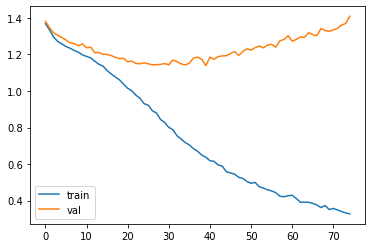

In [200]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.legend(['train', 'val'])

In [201]:
running_loss = 0.0
running_corrects = 0
model.eval()

# Iterate over data.
for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = loss_func(outputs, labels.long())

    # statistics
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) / inputs.size(0)
epoch_loss = running_loss / len(testloader)
print('Test Loss: {:.4f}'.format(epoch_loss))
print('Test Acc: {:.4f}'.format(running_corrects / len(testloader)))
print()

Test Loss: 1.1105
Test Acc: 0.5128



In [202]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE 481 Capstone/model_multi.pth')

In [203]:
model.eval()
datatestiter = iter(testloader)
input_test, labels_test = datatestiter.next()
input_test = input_test.to(device)
labels_test = labels_test.to(device)
output_test = model(input_test)
_, preds = torch.max(output_test, 1)
print(preds.shape)
print(labels_test.shape)
print('preds',preds[0:8])
print('labels', labels_test[0:8])
print(torch.sum(preds == labels_test) / len(labels_test))

torch.Size([128])
torch.Size([128])
preds tensor([3, 3, 3, 3, 0, 2, 3, 1], device='cuda:0')
labels tensor([3., 3., 3., 2., 2., 2., 3., 1.], device='cuda:0')
tensor(0.5781, device='cuda:0')
